## Tutorial on large-scale Thompson sampling

This demo currently considers four approaches to discrete Thompson sampling on `m` candidates points:

1. **Exact sampling with Cholesky:** Computing a Cholesky decomposition of the corresponding `m x m` covariance matrix which reuqires `O(m^3)` computational cost and `O(m^2)` space. This is the standard approach to sampling from a Gaussian process, but the quadratic memory usage and cubic compliexity limits the number of candidate points.

2. **Contour integral quadrature (CIQ):** CIQ [1] is a Krylov subspace method combined with a rational approximation that can be used for computing matrix square roots of covariance matrices, which is the main bottleneck when sampling from a Gaussian process. CIQ relies on computing matrix vector multiplications with the exact kernel matrix which requires `O(m^2)` computational complexity and space.  The space complexity can be lowered to `O(m)` by using [KeOps](https://github.com/getkeops/keops), which is necessary to scale to large values of `m`.

3. **Lanczos:** Rather than using CIQ, we can solve the linear systems `K^(1/2) v = b` using Lanczos and the conjugate gradient (CG) method. This will be faster than CIQ, but will generally produce samples of worse quality. Similarly to CIQ, we need to use KeOps as we reqiuire computing matrix vector multiplications with the exact kernel matrix.

4. **Random Fourier features (RFFs):** The RFF kernel was originally proposed in [2] and we use it as implemented in GPyTorch. RFFs are computationally cheap to work with as the computational cost and space are both `O(km)` where `k` is the number of Fourier features.  Note that while Cholesky and CIQ are able to generate exact samples from the GP model, RFFs are an unbiased approximation and the resulting samples often aren't perfectly calibrated. 


[1] [Pleiss, Geoff, et al. "Fast matrix square roots with applications to Gaussian processes and Bayesian optimization.", Advances in neural information processing systems (2020)](https://proceedings.neurips.cc/paper/2020/file/fcf55a303b71b84d326fb1d06e332a26-Paper.pdf)

[2] [Rahimi, Ali, and Benjamin Recht. "Random features for large-scale kernel machines.", Advances in neural information processing systems (2007)](https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf)

In [1]:
import os
import time
from contextlib import ExitStack

import gpytorch
import gpytorch.settings as gpts
import torch
from gpytorch.constraints import Interval
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import MaternKernel, RFFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.quasirandom import SobolEngine

from botorch.fit import fit_gpytorch_mll
from botorch.generation import MaxPosteriorSampling
from botorch.models import SingleTaskGP
from botorch.test_functions import Hartmann
from botorch.utils.transforms import unnormalize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

c:\Users\EGatiyatullin\Desktop\MyProjects\repos\2024\masters_thesis_blockchain\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
hart6 = Hartmann(dim=6, negate=True).to(device=device, dtype=dtype)
dim = 1

import numpy as np
def eval_objective(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return -np.cos(x)

In [43]:
def get_initial_points(dim, n_pts, seed=None):
    sobol = SobolEngine(dimension=dim, scramble=True, seed=seed)
    X_init = sobol.draw(n=n_pts).to(dtype=dtype, device=device)
    return X_init


get_initial_points(1,10)

tensor([[0.8519],
        [0.2792],
        [0.2476],
        [0.6338],
        [0.6120],
        [0.0070],
        [0.4761],
        [0.8926],
        [0.9909],
        [0.3781]], dtype=torch.float64)

In [35]:
def generate_batch(
    X,
    Y,
    batch_size,
    n_candidates,
    sampler="cholesky",  # "cholesky", "ciq", "rff"
    use_keops=False,
):
    assert sampler in ("cholesky", "ciq", "rff", "lanczos")
    assert X.min() >= 0.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))

    # NOTE: We probably want to pass in the default priors in SingleTaskGP here later
    kernel_kwargs = {"nu": 2.5, "ard_num_dims": X.shape[-1]}
    if sampler == "rff":
        base_kernel = RFFKernel(**kernel_kwargs, num_samples=1024)
    else:
        base_kernel = (
            KMaternKernel(**kernel_kwargs)
            if use_keops
            else MaternKernel(**kernel_kwargs)
        )
    covar_module = ScaleKernel(base_kernel)

    # Fit a GP model
    train_Y = (Y - Y.mean()) / Y.std()
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    model = SingleTaskGP(X, train_Y, likelihood=likelihood, covar_module=covar_module)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    # Draw samples on a Sobol sequence
    sobol = SobolEngine(X.shape[-1], scramble=True)
    X_cand = sobol.draw(n_candidates).to(dtype=dtype, device=device)

    # Thompson sample
    with ExitStack() as es:
        if sampler == "cholesky":
            es.enter_context(gpts.max_cholesky_size(float("inf")))
        elif sampler == "ciq":
            es.enter_context(gpts.fast_computations(covar_root_decomposition=True))
            es.enter_context(gpts.max_cholesky_size(0))
            es.enter_context(gpts.ciq_samples(True))
            es.enter_context(
                gpts.minres_tolerance(2e-3)
            )  # Controls accuracy and runtime
            es.enter_context(gpts.num_contour_quadrature(15))
        elif sampler == "lanczos":
            es.enter_context(
                gpts.fast_computations(
                    covar_root_decomposition=True, log_prob=True, solves=True
                )
            )
            es.enter_context(gpts.max_lanczos_quadrature_iterations(10))
            es.enter_context(gpts.max_cholesky_size(0))
            es.enter_context(gpts.ciq_samples(False))
        elif sampler == "rff":
            es.enter_context(gpts.fast_computations(covar_root_decomposition=True))

    with torch.no_grad():
        thompson_sampling = MaxPosteriorSampling(model=model, replacement=False)
        X_next = thompson_sampling(X_cand, num_samples=batch_size)

    return X_next

In [36]:
def run_optimization(
    sampler, n_candidates, n_init, max_evals, batch_size, use_keops=False, seed=None
):
    X = get_initial_points(dim, n_init, seed)
    Y = torch.tensor(
        [eval_objective(x) for x in X], dtype=dtype, device=device
    ).unsqueeze(-1)
    print(f"{len(X)}) Best value: {Y.max().item():.2e}")

    while len(X) < max_evals:
        # Create a batch
        start = time.monotonic()
        X_next = generate_batch(
            X=X,
            Y=Y,
            batch_size=min(batch_size, max_evals - len(X)),
            n_candidates=n_candidates,
            sampler=sampler,
            use_keops=use_keops,
        )
        end = time.monotonic()
        print(f"Generated batch in {end - start:.1f} seconds")
        Y_next = torch.tensor(
            [eval_objective(x) for x in X_next], dtype=dtype, device=device
        ).unsqueeze(-1)

        # Append data
        X = torch.cat((X, X_next), dim=0)
        Y = torch.cat((Y, Y_next), dim=0)

        print(f"{len(X)}) Best value: {Y.max().item():.2e}")
    return X, Y

In [37]:
batch_size = 5
n_init = 10
max_evals = 50
seed = 12345  # To get the same Sobol points

shared_args = {
    "n_init": n_init,
    "max_evals": max_evals,
    "batch_size": batch_size,
    "seed": seed,
}

In [21]:
# This tutorial will run much faster if KeOps + a GPU is used
USE_KEOPS = False

if USE_KEOPS:
    import pykeops
    from gpytorch.kernels.keops import MaternKernel as KMaternKernel

N_CAND = 1000
if USE_KEOPS:
    N_CAND = 50_000
if SMOKE_TEST:
    N_CAND = 10
    
N_CAND_CHOL = 1000

## Track memory footprint

## Cholesky

In [38]:
X_chol, Y_chol = run_optimization("cholesky", N_CAND_CHOL, **shared_args)

10) Best value: -6.11e-01


c:\Users\EGatiyatullin\Desktop\MyProjects\repos\2024\masters_thesis_blockchain\.venv\lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\EGatiyatullin\Desktop\MyProjects\repos\2024\masters_thesis_blockchain\.venv\lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\EGatiyatullin\Desktop\MyProjects\repos\2024\masters_thesis_blockchain\.venv\lib\site-packages\botorch\optim\fit.py:102: OptimizationWarning: `scipy_minimize` terminated with status 3, displaying original message from `scipy.optimize.minimize`: ABNORMAL_TERMINATION_IN_LNSRCH
  warn(
c:\Users\EGatiyatullin\Desktop\MyProjects\repos\2024\masters_thesis_blockchain\.venv\lib\site-packages\botorch\optim\fit.py:

ModelFittingError: All attempts to fit the model have failed. For more information, try enabling botorch.settings.debug mode.

## RFFs

In [23]:
X_rff, Y_rff = run_optimization("rff", N_CAND, **shared_args)

10) Best value: 6.72e-01
Generated batch in 0.4 seconds
15) Best value: 6.72e-01
Generated batch in 0.6 seconds
20) Best value: 6.72e-01
Generated batch in 0.5 seconds
25) Best value: 2.84e+00
Generated batch in 0.7 seconds
30) Best value: 2.84e+00
Generated batch in 0.8 seconds
35) Best value: 2.84e+00
Generated batch in 0.5 seconds
40) Best value: 2.84e+00
Generated batch in 0.7 seconds
45) Best value: 2.84e+00
Generated batch in 0.7 seconds
50) Best value: 2.84e+00


## Lanczos

In [24]:
X_lanczos, Y_lanczos = run_optimization("lanczos", N_CAND, use_keops=USE_KEOPS, **shared_args)

10) Best value: 6.72e-01
Generated batch in 0.4 seconds
15) Best value: 1.90e+00
Generated batch in 0.3 seconds
20) Best value: 1.96e+00
Generated batch in 0.4 seconds
25) Best value: 1.96e+00
Generated batch in 0.3 seconds
30) Best value: 2.36e+00
Generated batch in 0.3 seconds
35) Best value: 2.36e+00
Generated batch in 0.4 seconds
40) Best value: 2.95e+00
Generated batch in 0.3 seconds
45) Best value: 3.15e+00
Generated batch in 0.3 seconds
50) Best value: 3.15e+00


## CIQ with 50,000 candidates

In [25]:
X_ciq, Y_ciq = run_optimization("ciq", N_CAND, use_keops=USE_KEOPS, **shared_args)

10) Best value: 6.72e-01
Generated batch in 0.4 seconds
15) Best value: 2.63e+00
Generated batch in 0.2 seconds
20) Best value: 2.63e+00
Generated batch in 0.3 seconds
25) Best value: 2.63e+00
Generated batch in 0.3 seconds
30) Best value: 2.63e+00
Generated batch in 0.3 seconds
35) Best value: 2.67e+00
Generated batch in 0.3 seconds
40) Best value: 2.67e+00
Generated batch in 0.4 seconds
45) Best value: 2.74e+00
Generated batch in 0.2 seconds
50) Best value: 2.74e+00


## Plot

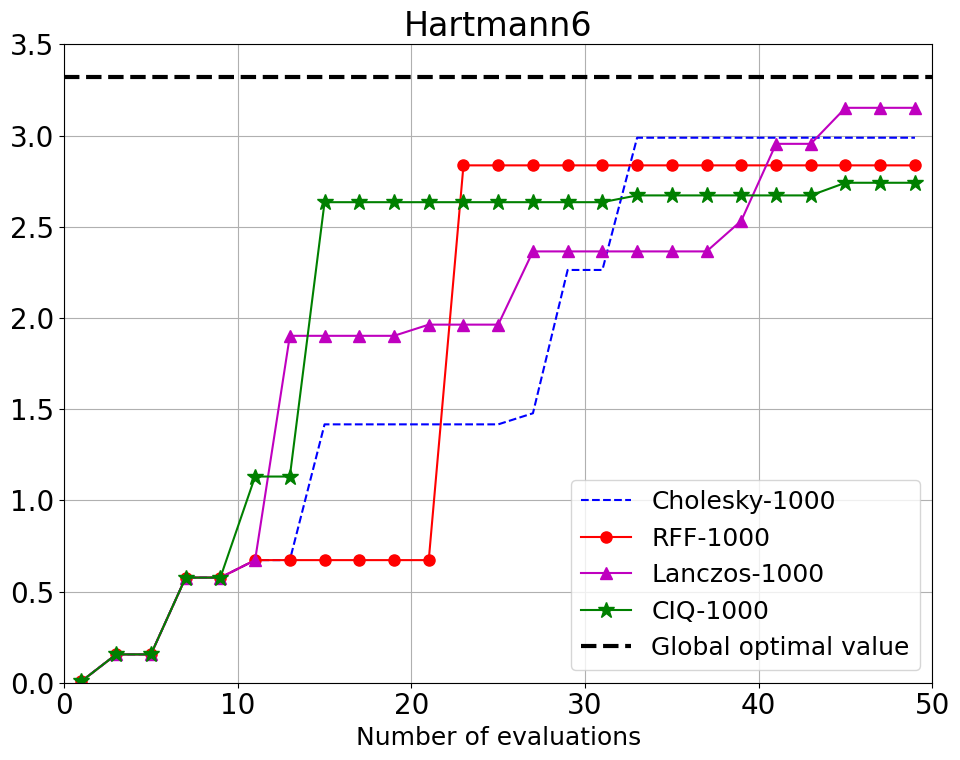

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(10, 8))
matplotlib.rcParams.update({"font.size": 20})

results = [
    (Y_chol.cpu(), f"Cholesky-{N_CAND_CHOL}", "b", "", 14, "--"),
    (Y_rff.cpu(), f"RFF-{N_CAND}", "r", ".", 16, "-"),
    (Y_lanczos.cpu(), f"Lanczos-{N_CAND}", "m", "^", 9, "-"),
    (Y_ciq.cpu(), f"CIQ-{N_CAND}", "g", "*", 12, "-"),
]

optimum = hart6.optimal_value

ax = fig.add_subplot(1, 1, 1)
names = []
for res, name, c, m, ms, ls in results:
    names.append(name)
    fx = res.cummax(dim=0)[0]
    t = 1 + np.arange(len(fx))
    plt.plot(t[0::2], fx[0::2], c=c, marker=m, linestyle=ls, markersize=ms)

plt.plot([0, max_evals], [hart6.optimal_value, hart6.optimal_value], "k--", lw=3)
plt.xlabel("Function value", fontsize=18)
plt.xlabel("Number of evaluations", fontsize=18)
plt.title("Hartmann6", fontsize=24)
plt.xlim([0, max_evals])
plt.ylim([0, 3.5])

plt.grid(True)
plt.tight_layout()
plt.legend(
    names + ["Global optimal value"],
    loc="lower right",
    ncol=1,
    fontsize=18,
)
plt.show()

In [ ]:
Y_chol.shape